In [37]:
from eda_functions import *

In [38]:
def run_all_visualizations(data):
    print("Running all visualizations...")
    
    # 1. Price and Volume Analysis
    plot_candlestick_volume(data)
    plot_price_with_mas(data)
    
    # 2. Technical Indicator Visualizations
    plot_bollinger_bands(data)
    plot_rsi(data)
    plot_macd(data)
    plot_stochastic(data)
    
    # 3. Correlation Analysis
    plot_correlation_heatmap(data)
    
    
    # 4. Distribution Analysis
    plot_return_distributions(data)
    plot_qq_plot(data)
    plot_return_by_period(data)
    
    # 5. Volatility Analysis
    plot_volatility_metrics(data)
    plot_rolling_std(data)
    plot_bb_width(data)
    
    # 6. Moving Average Analysis
    plot_ma_crossover(data)
    plot_price_rel_to_ma(data)
    
    # 7. Volume Analysis
    plot_obv(data)
    
    
    print("All visualizations completed!")

C:\Users\User\AppData\Local\Temp\ipykernel_36876\52067982.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


Engineering features...
Running all visualizations...


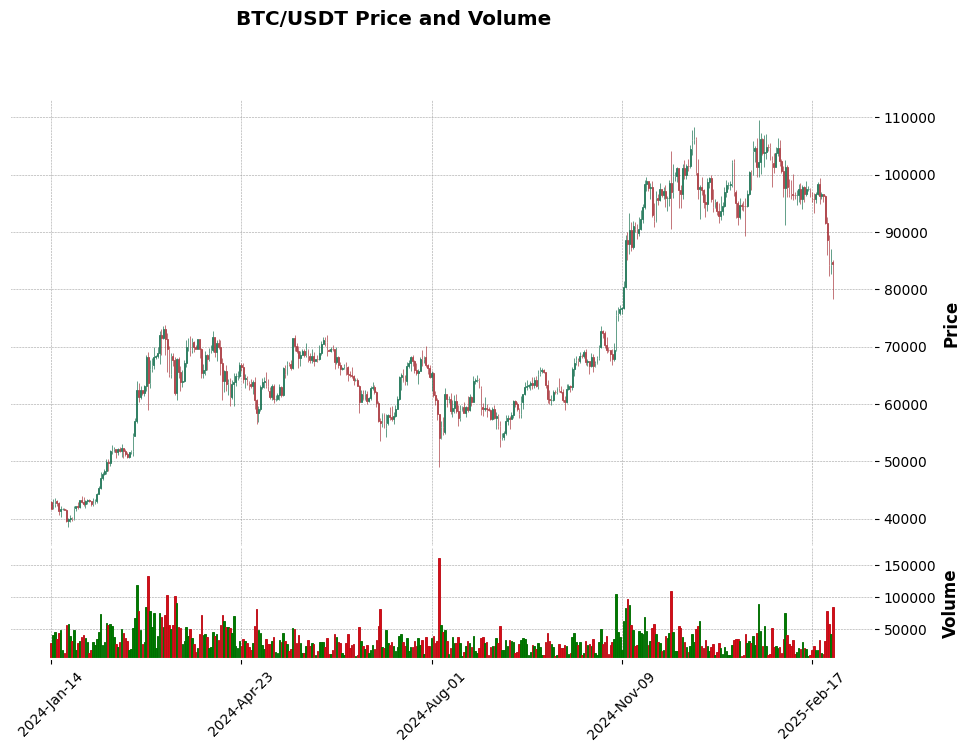

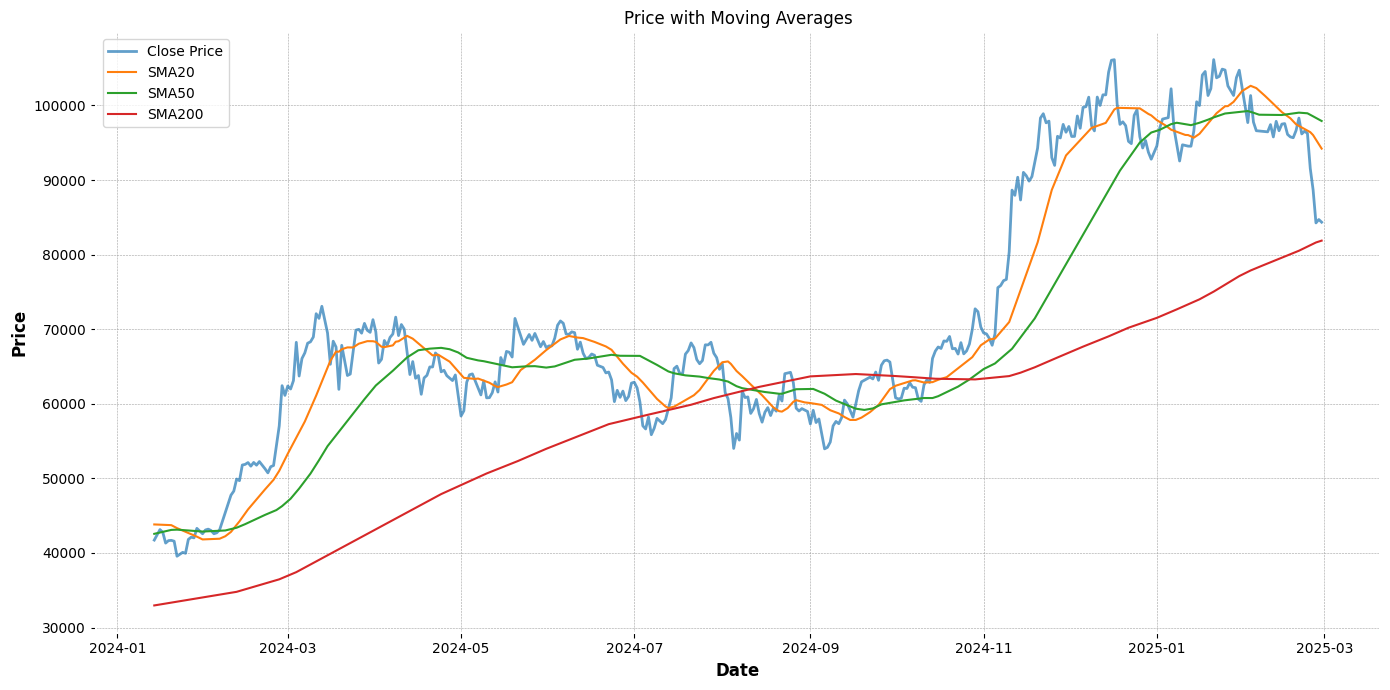

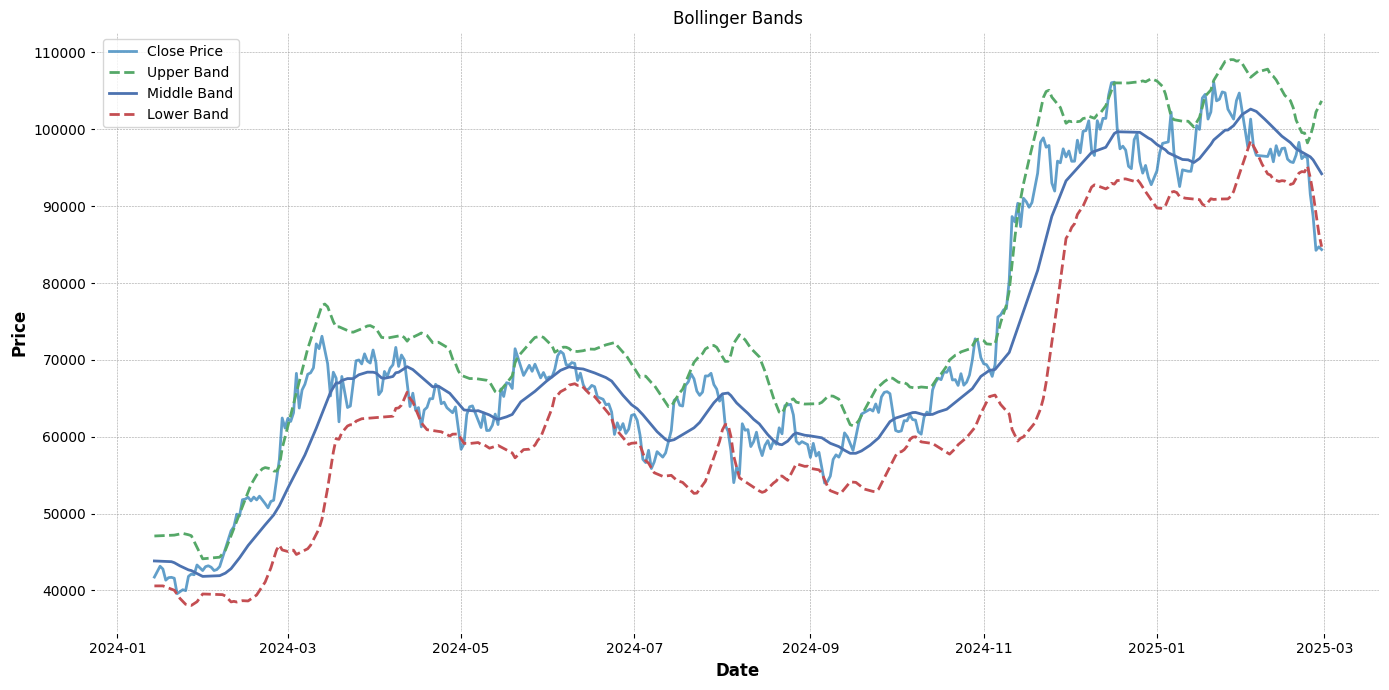

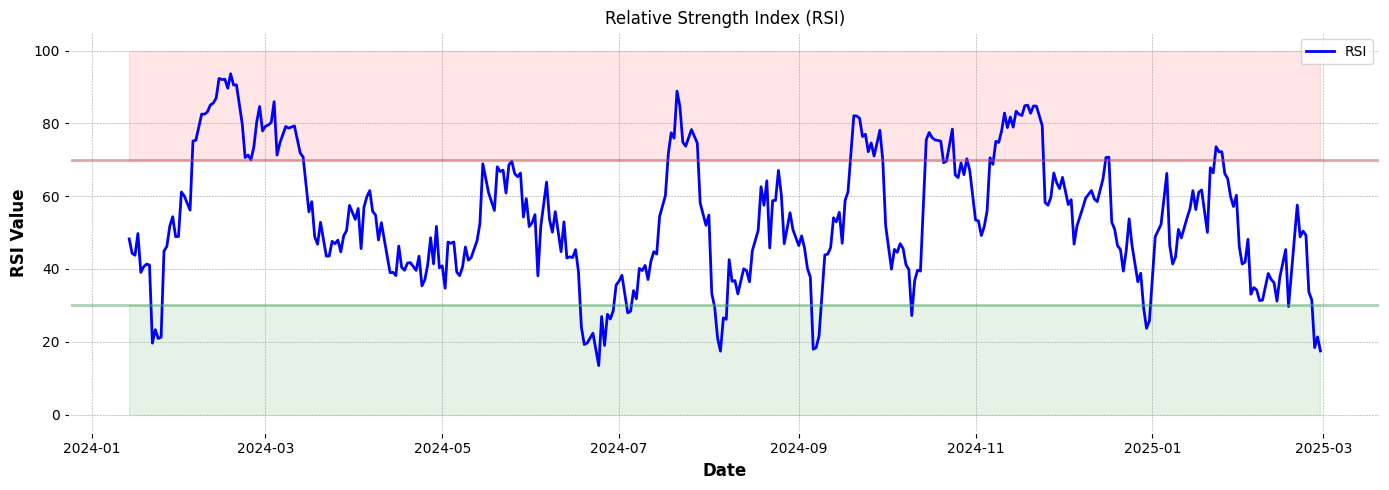

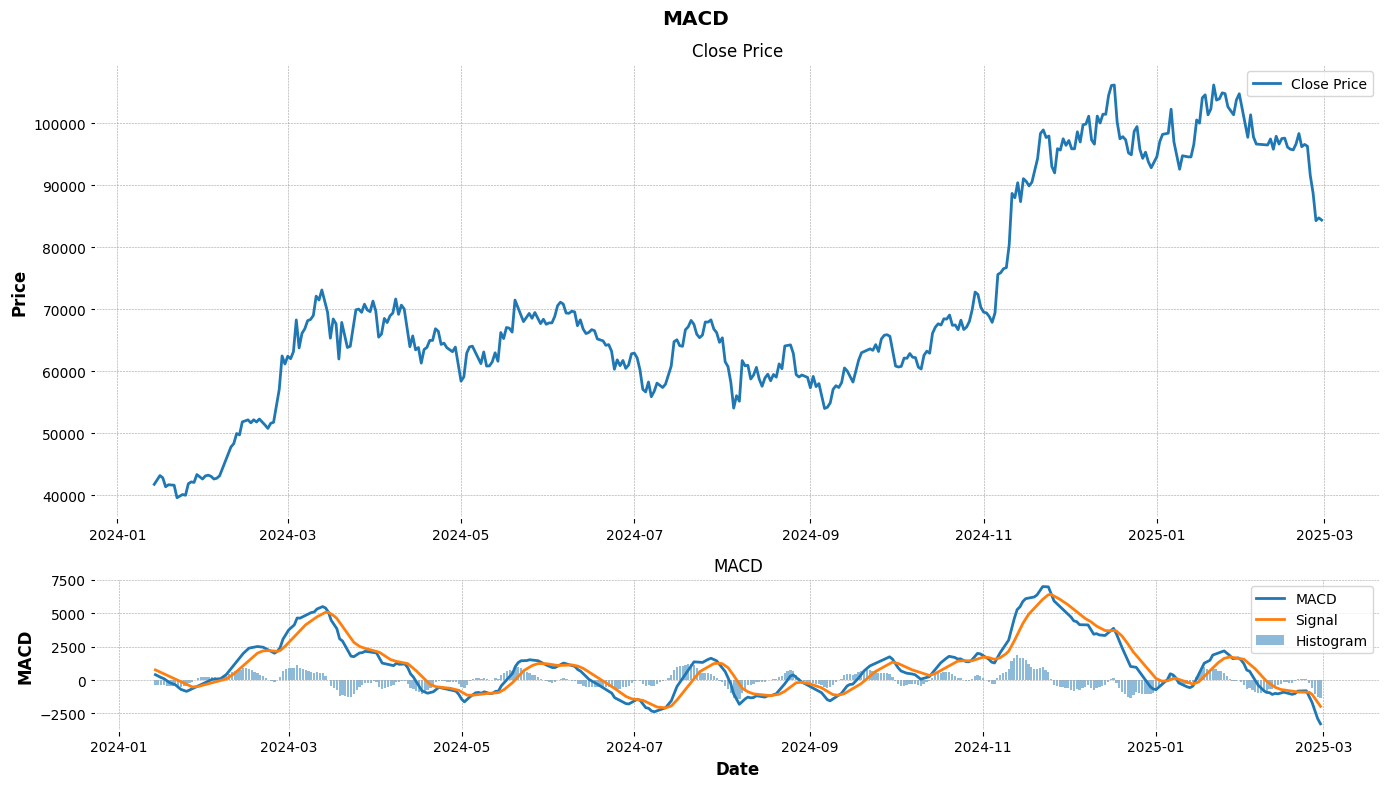

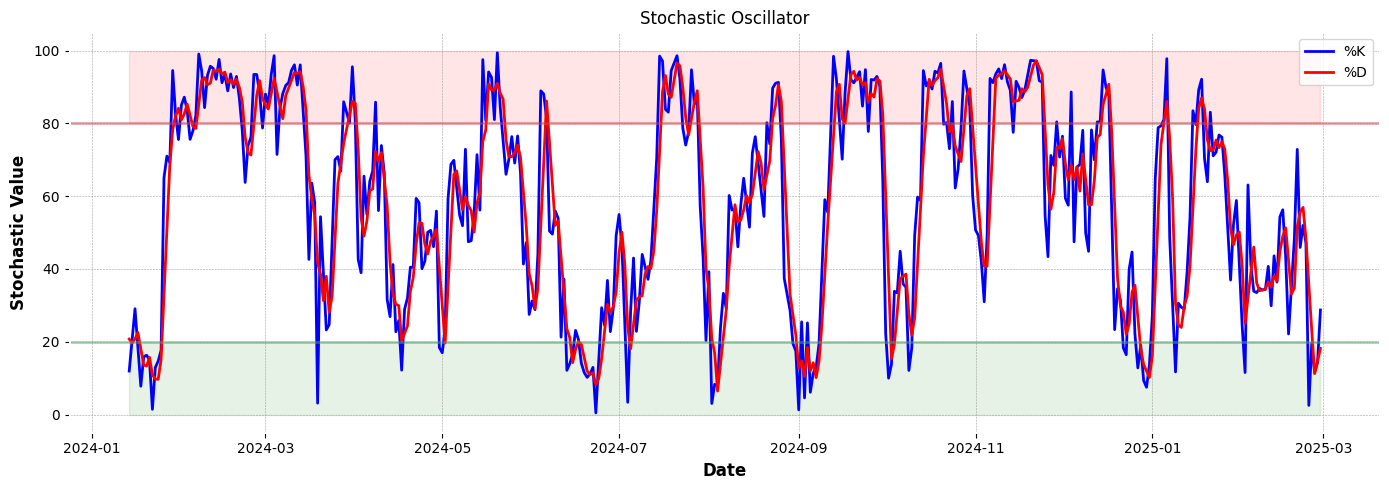

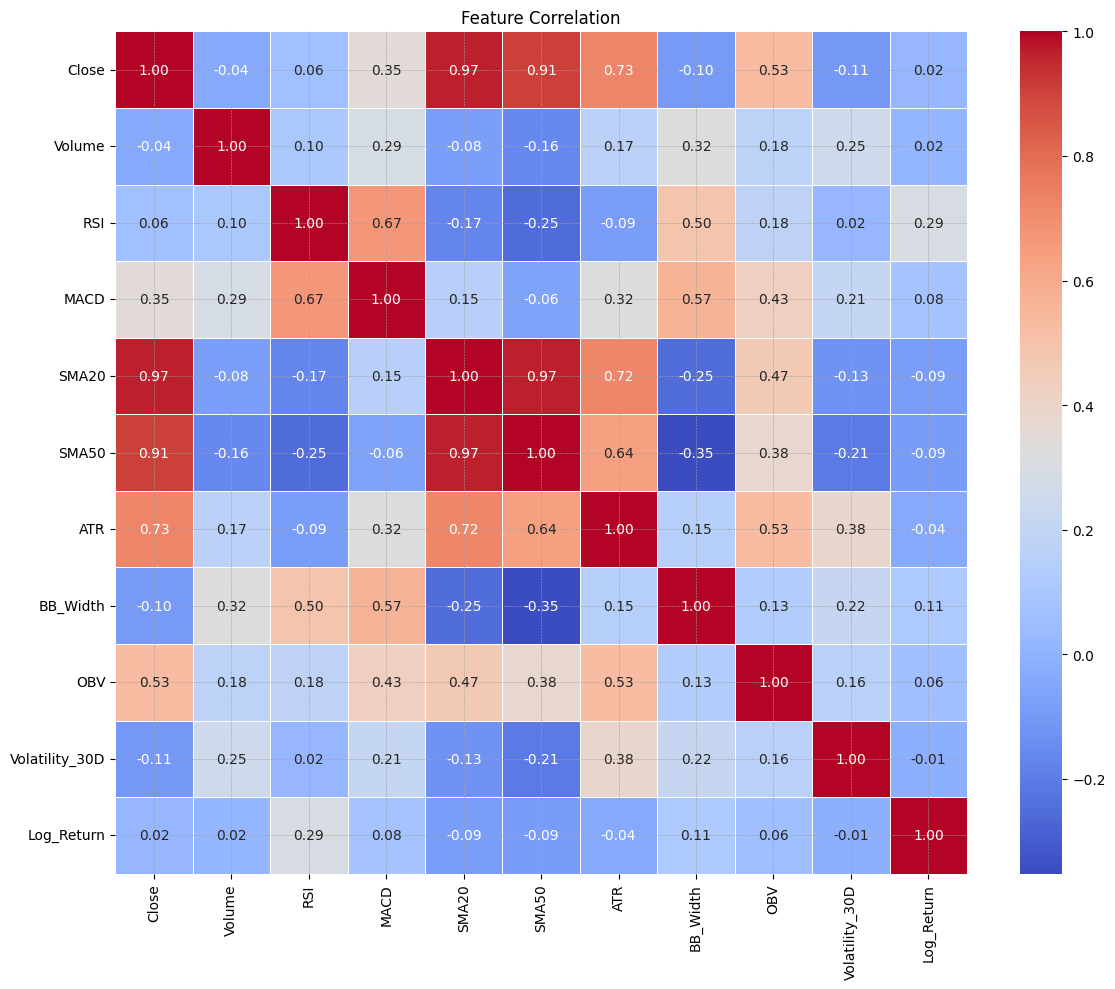

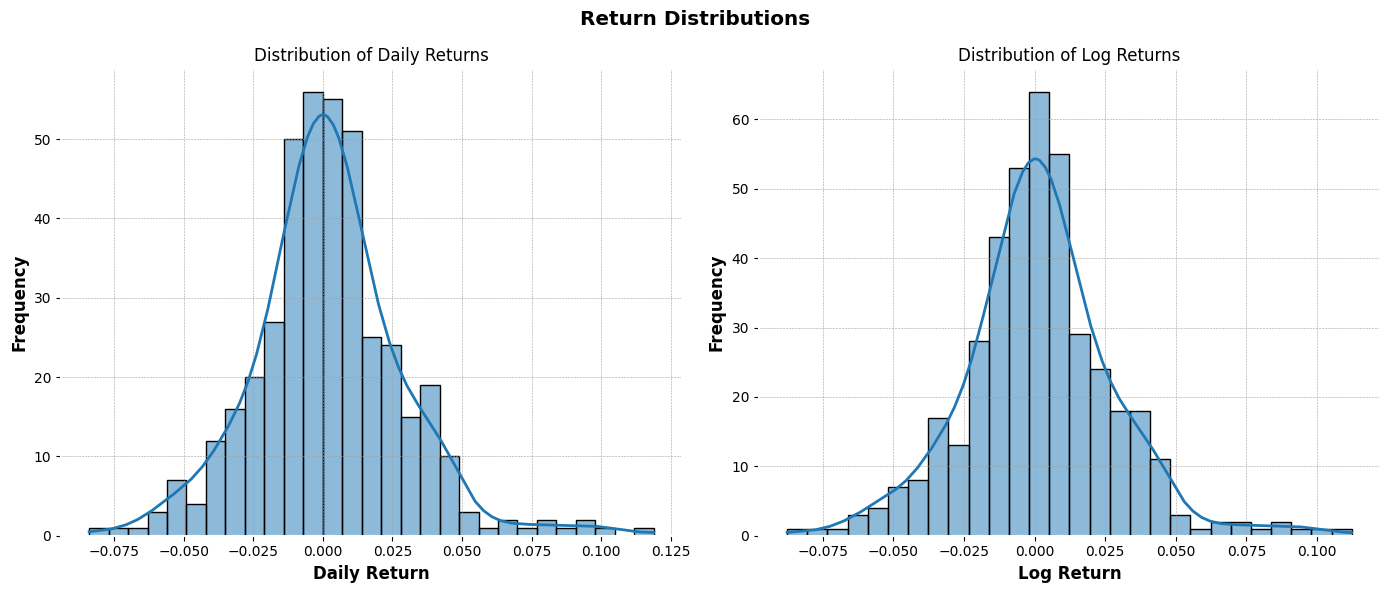

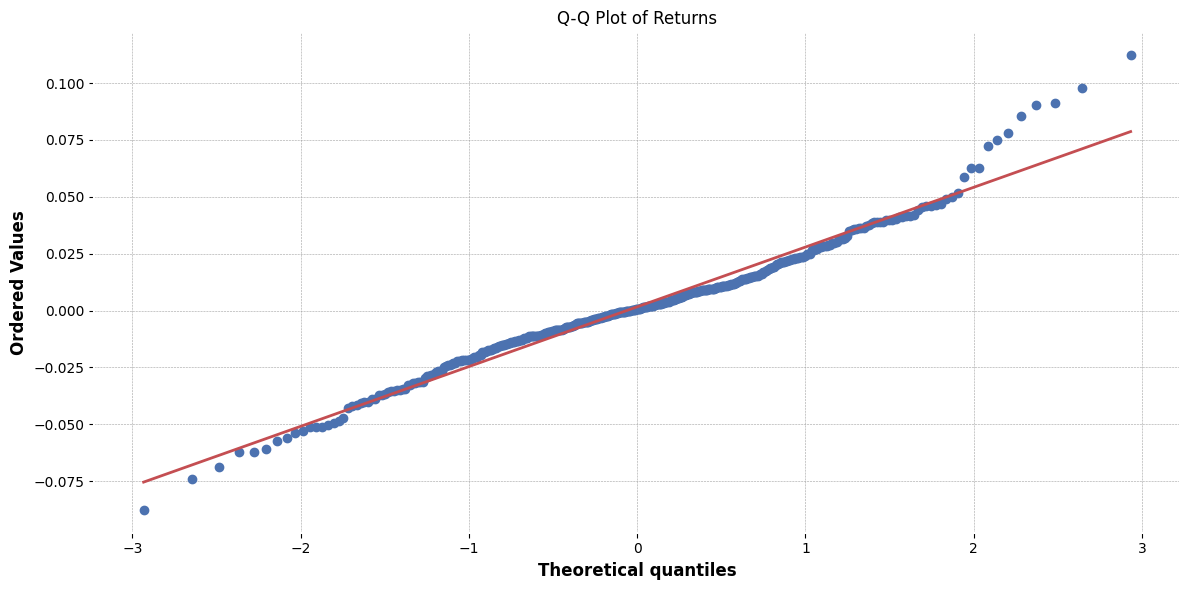

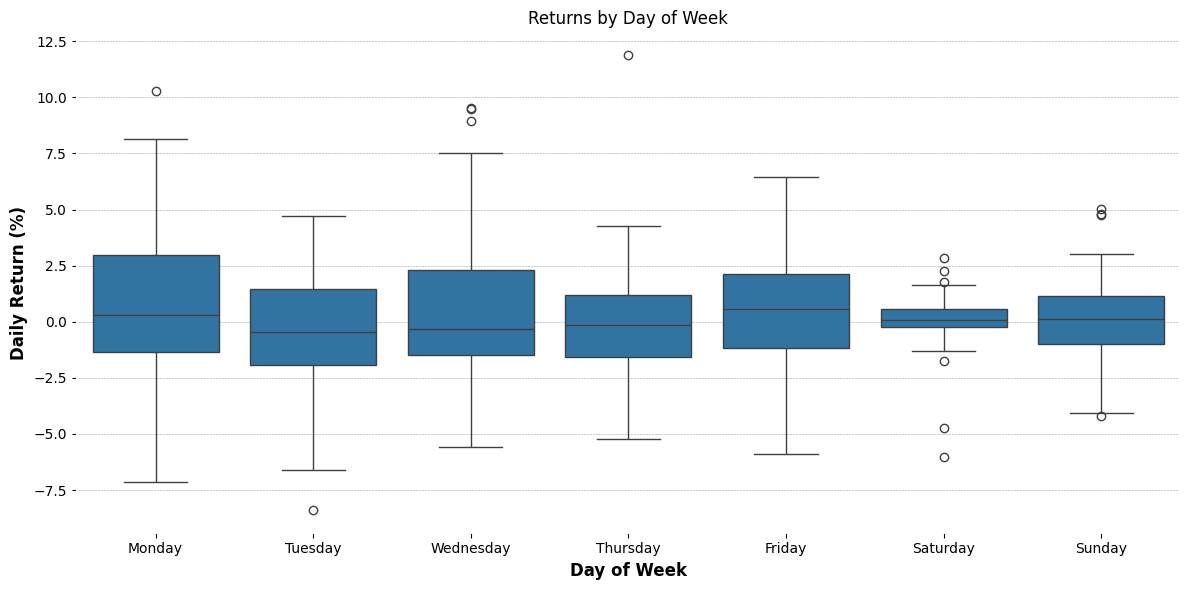

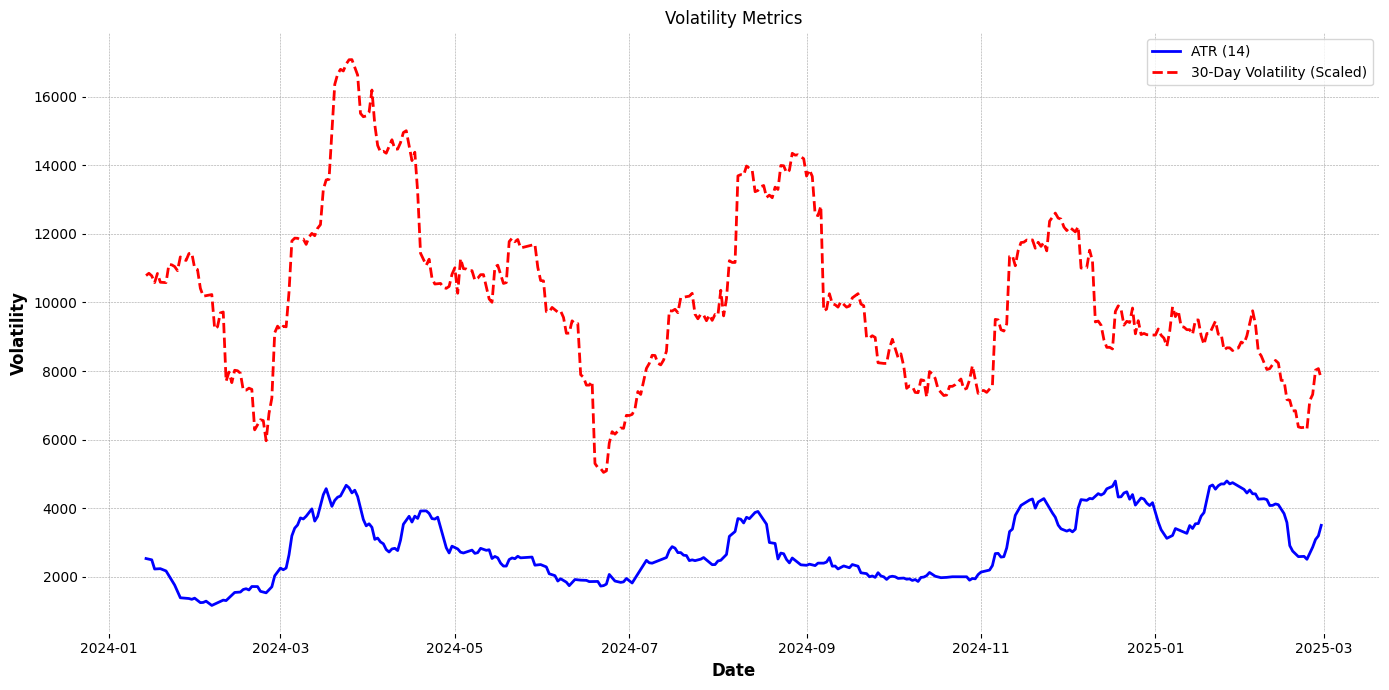

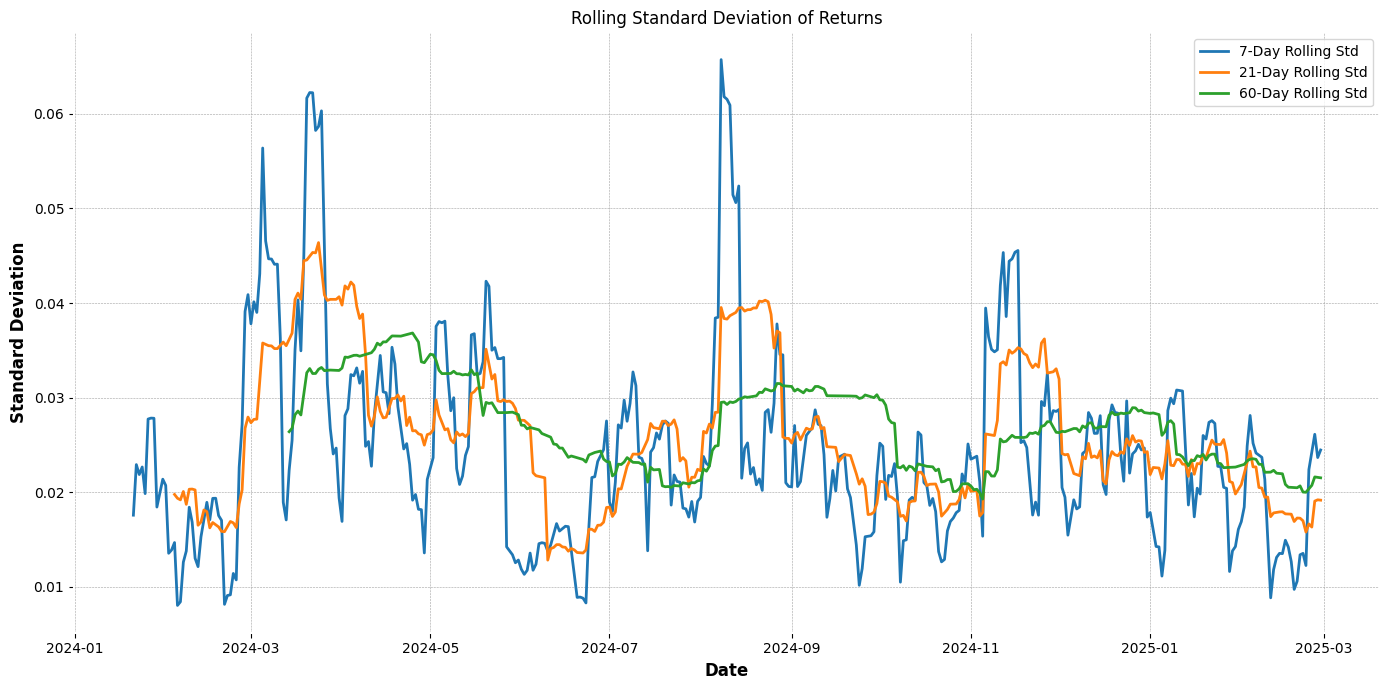

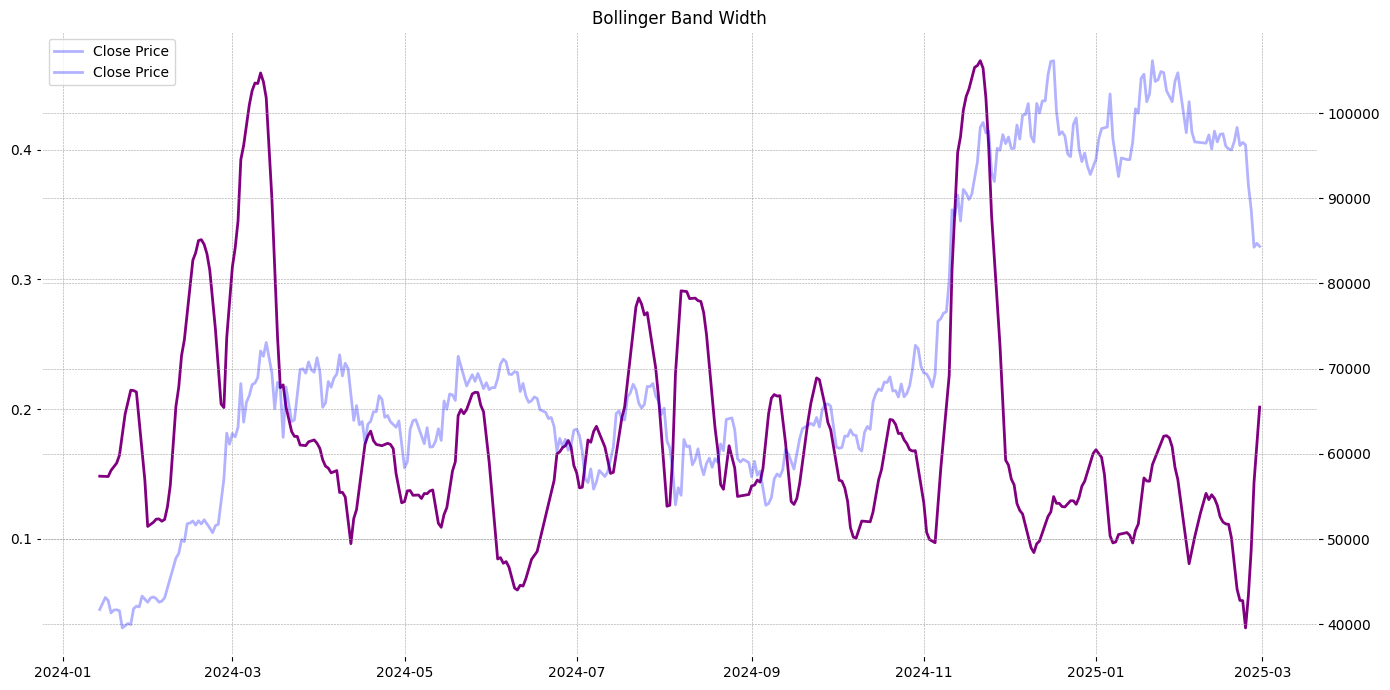

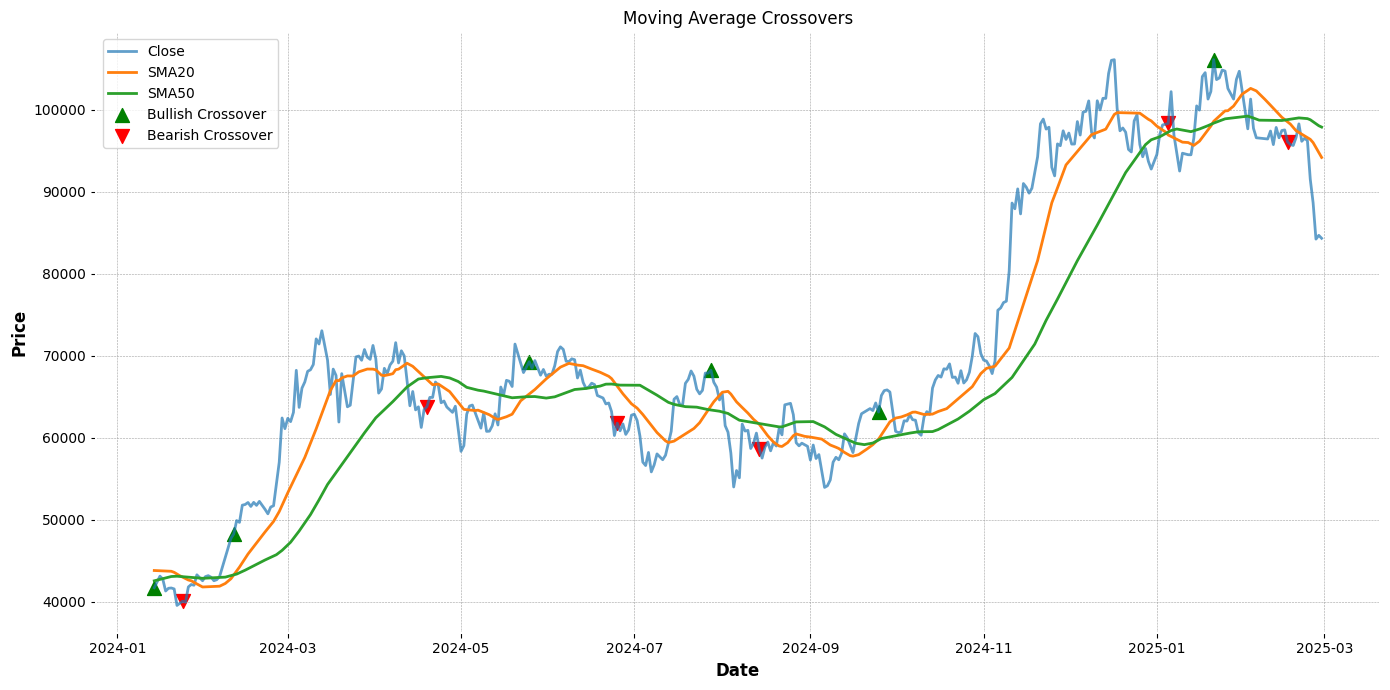

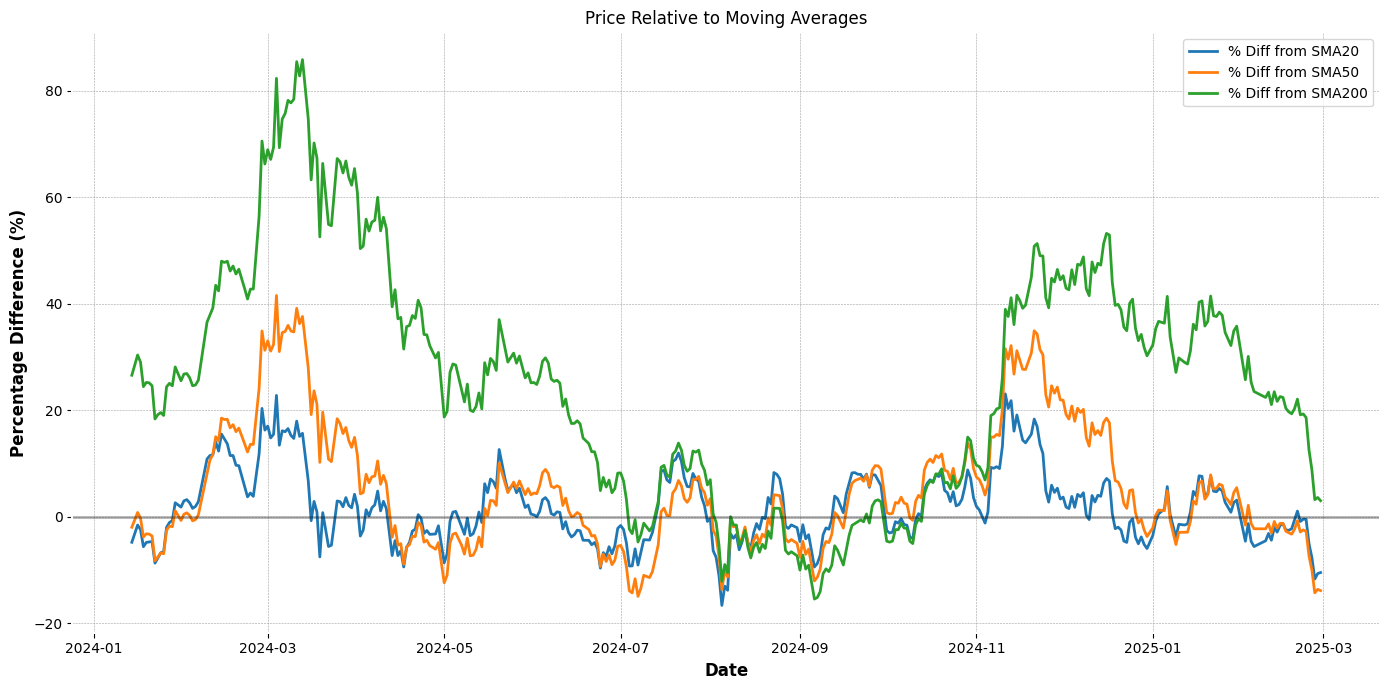

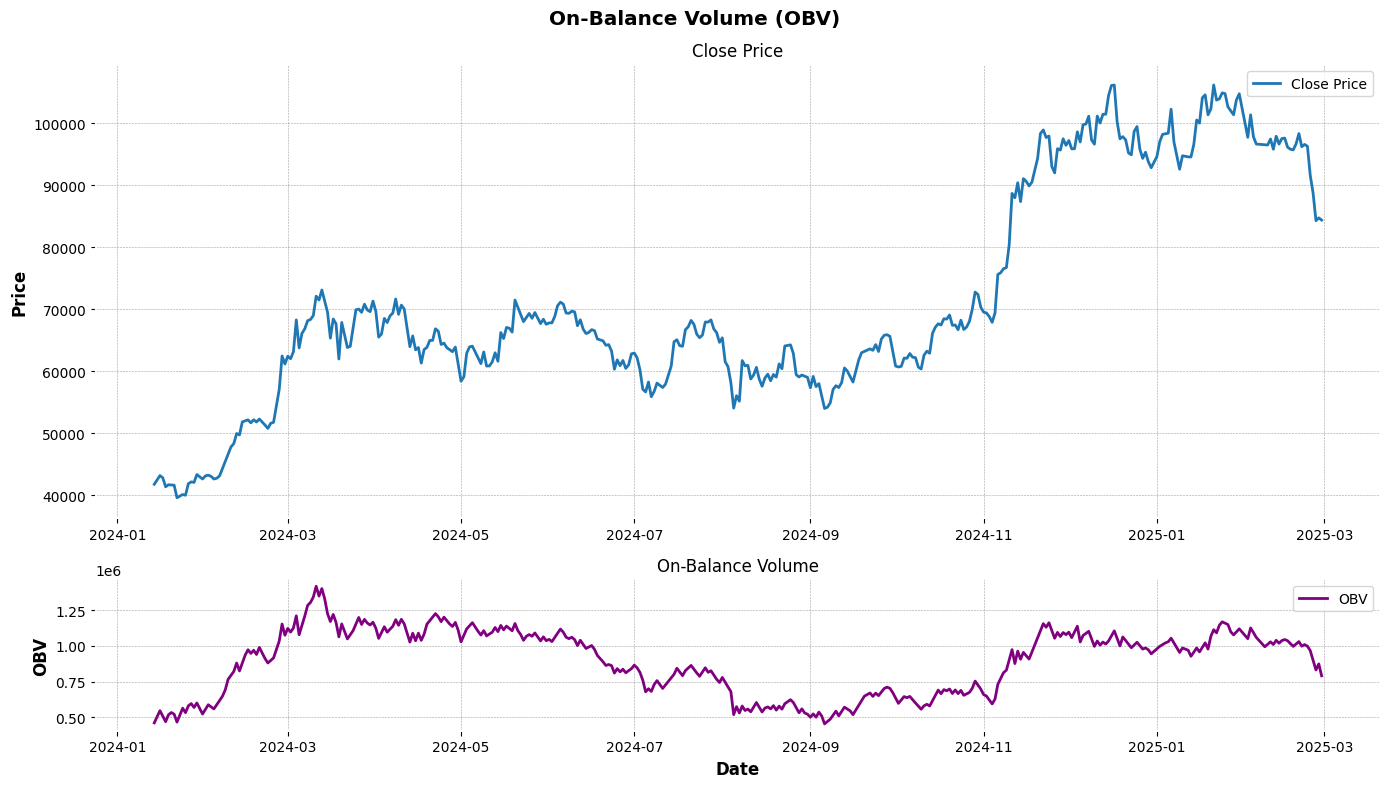

All visualizations completed!


In [41]:
from datetime import datetime
plt.style.use('seaborn-darkgrid')
sns.set_theme(style="darkgrid")

symbol = 'BTC/USDT'
time_interval = '1d'
start_date = datetime(2023, 6, 28)
end_date = '2025-02-28'
classification = True

df = create_raw_stock_dataset(symbol, time_interval, start_date)
df = fetch_data(symbol, time_interval, start_date, end_date=end_date)
print("Engineering features...")
df = engineer_features(df)

run_all_visualizations(df)

In [ ]:
def engineer_features(df):
    """Generate technical indicators and other features."""
    # Make a copy to avoid SettingWithCopyWarning
    data = df.copy()
    
    # Technical Indicators
    # Momentum indicators
    # RSI
    data['RSI'] = calculate_rsi(data['Close'], 14)

    # MACD
    data['MACD'], data['MACD_Signal'], data['MACD_Hist'] = calculate_macd(data['Close'])

    # stochastic
    data['Stoch_K'], data['Stoch_D'] = calculate_stoch(data)

    # Simple Moving Averages
    data['SMA20'] = data['Close'].rolling(window=20).mean()
    data['SMA50'] = data['Close'].rolling(window=50).mean()
    data['SMA200'] = data['Close'].shift(1).rolling(200).mean()

    # Exponential Moving Average
    data['EMA20'] = data['Close'].ewm(span=20, adjust=False).mean()

    # ADX
    data['ADX'] = calculate_adx(data.shift(1))

    # ATR
    data['ATR'] = calculate_atr(data)

    # Bollinger Bands
    data['BB_Upper'], data['BB_Middle'], data['BB_Lower'] = calculate_bbands(data)
    data['BB_Width'] = (data['BB_Upper'] - data['BB_Lower']) / data['BB_Middle']

    # OBV
    data['OBV'] = calculate_obv(data)
    
    # Calculate VWAP manually
    data['Typical_Price'] = (data['High'] + data['Low'] + data['Close']) / 3
    data['VP'] = data['Typical_Price'] * data['Volume']
    data['VWAP'] = data['VP'].rolling(window=20).sum() / data['Volume'].rolling(window=20).sum()
    
    # Lag features
    for lag in [1, 3, 7]:
        data[f'Return_Lag_{lag}'] = data['Close'].pct_change(lag)
    
    # Rolling statistics
    for window in [7, 30]:
        data[f'Std_Dev_{window}D'] = data['Close'].rolling(window=window).std()
        data[f'MA_{window}D'] = data['Close'].rolling(window=window).mean()
        data[f'Z_Score_{window}D'] = (data['Close'] - data[f'MA_{window}D']) / data[f'Std_Dev_{window}D']
    
    # Price relative to moving averages
    data['Close_Rel_SMA20'] = data['Close'] / data['SMA20'] - 1
    data['Close_Rel_SMA50'] = data['Close'] / data['SMA50'] - 1
    data['Close_Rel_SMA200'] = data['Close'] / data['SMA200'] - 1
    
    # Crossover signals
    data['SMA20_Cross_SMA50'] = (data['SMA20'] > data['SMA50']).astype(int)
    
    # Additional features
    data['High_Low_Range'] = data['High'] - data['Low']
    data['Close_Open_Range'] = abs(data['Close'] - data['Open'])
    data['Range_Ratio'] = data['Close_Open_Range'] / data['High_Low_Range']
    
    # Cryptocurrency-specific indicators
    # Logarithmic returns may work better for highly volatile assets
    data['Log_Return'] = np.log(data['Close'] / data['Close'].shift(1))
    
    # Volatility measures
    data['Volatility_30D'] = data['Log_Return'].rolling(window=30).std() * np.sqrt(30)
    
    # Drop rows with NaN values after feature engineering
    data = data.dropna()
    
    return data


# 1. PRICE AND VOLUME ANALYSIS
# ------------------------------

# Candlestick chart with volume
def plot_candlestick_volume(data, title="BTC/USDT Price and Volume"):
    # Convert data to format required by mplfinance
    ohlc_data = data[['Open', 'High', 'Low', 'Close', 'Volume']].copy()
    
    # Plot candlestick chart with volume
    mpf.plot(ohlc_data, type='candle', volume=True, 
             title=title,
             style='charles',
             figsize=(12, 8),
             panel_ratios=(4, 1))

# Line plot of closing prices with moving averages
def plot_price_with_mas(data, title="Price with Moving Averages"):
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, data['Close'], label='Close Price', alpha=0.7)
    plt.plot(data.index, data['SMA20'], label='SMA20', linewidth=1.5)
    plt.plot(data.index, data['SMA50'], label='SMA50', linewidth=1.5)
    plt.plot(data.index, data['SMA200'], label='SMA200', linewidth=1.5)
    
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# 2. TECHNICAL INDICATOR VISUALIZATIONS
# -------------------------------------

# Bollinger Bands
def plot_bollinger_bands(data, title="Bollinger Bands"):
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, data['Close'], label='Close Price', alpha=0.7)
    plt.plot(data.index, data['BB_Upper'], label='Upper Band', linestyle='--', color='g')
    plt.plot(data.index, data['BB_Middle'], label='Middle Band', linestyle='-', color='b')
    plt.plot(data.index, data['BB_Lower'], label='Lower Band', linestyle='--', color='r')
    
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# RSI
def plot_rsi(data, title="Relative Strength Index (RSI)"):
    plt.figure(figsize=(14, 5))
    plt.plot(data.index, data['RSI'], label='RSI', color='blue')
    plt.axhline(y=70, color='r', linestyle='-', alpha=0.5)
    plt.axhline(y=30, color='g', linestyle='-', alpha=0.5)
    plt.fill_between(data.index, y1=70, y2=100, color='red', alpha=0.1)
    plt.fill_between(data.index, y1=0, y2=30, color='green', alpha=0.1)
    
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('RSI Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# MACD
def plot_macd(data, title="MACD"):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), gridspec_kw={'height_ratios': [3, 1]})
    
    # Price chart
    ax1.plot(data.index, data['Close'], label='Close Price')
    ax1.set_ylabel('Price')
    ax1.set_title('Close Price')
    ax1.legend()
    ax1.grid(True)
    
    # MACD
    ax2.plot(data.index, data['MACD'], label='MACD')
    ax2.plot(data.index, data['MACD_Signal'], label='Signal')
    ax2.bar(data.index, data['MACD_Hist'], label='Histogram', alpha=0.5)
    ax2.set_xlabel('Date')
    ax2.set_ylabel('MACD')
    ax2.set_title('MACD')
    ax2.legend()
    ax2.grid(True)
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Stochastic Oscillator
def plot_stochastic(data, title="Stochastic Oscillator"):
    plt.figure(figsize=(14, 5))
    plt.plot(data.index, data['Stoch_K'], label='%K', color='blue')
    plt.plot(data.index, data['Stoch_D'], label='%D', color='red')
    plt.axhline(y=80, color='r', linestyle='-', alpha=0.5)
    plt.axhline(y=20, color='g', linestyle='-', alpha=0.5)
    plt.fill_between(data.index, y1=80, y2=100, color='red', alpha=0.1)
    plt.fill_between(data.index, y1=0, y2=20, color='green', alpha=0.1)
    
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Stochastic Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 3. CORRELATION ANALYSIS
# -----------------------

# Correlation Heatmap
def plot_correlation_heatmap(data, title="Feature Correlation"):
    # Select numeric columns and compute correlation
    numeric_data = data.select_dtypes(include=[np.number])
    
    # Select important features to make the heatmap readable
    important_features = ['Close', 'Volume', 'RSI', 'MACD', 'SMA20', 'SMA50', 
                          'ATR', 'BB_Width', 'OBV', 'Volatility_30D', 'Log_Return']
    
    corr = numeric_data[important_features].corr()
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Scatter plots between key features
def plot_scatter_matrix(data, title="Scatter Matrix of Key Features"):
    features = ['Close', 'Volume', 'RSI', 'ATR', 'Log_Return']
    scatter_data = data[features]
    
    sns.pairplot(scatter_data, diag_kind='kde', plot_kws={'alpha': 0.6})
    plt.suptitle(title, y=1.02)
    plt.tight_layout()
    plt.show()

# 4. DISTRIBUTION ANALYSIS
# ------------------------

# Histograms of returns
def plot_return_distributions(data, title="Return Distributions"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Regular returns
    returns = data['Close'].pct_change().dropna()
    sns.histplot(returns, kde=True, ax=ax1)
    ax1.set_title('Distribution of Daily Returns')
    ax1.set_xlabel('Daily Return')
    ax1.set_ylabel('Frequency')
    
    # Log returns
    log_returns = data['Log_Return'].dropna()
    sns.histplot(log_returns, kde=True, ax=ax2)
    ax2.set_title('Distribution of Log Returns')
    ax2.set_xlabel('Log Return')
    ax2.set_ylabel('Frequency')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Q-Q plot of returns
def plot_qq_plot(data, title="Q-Q Plot of Returns"):
    from scipy import stats
    
    plt.figure(figsize=(12, 6))
    
    # Q-Q plot of log returns
    log_returns = data['Log_Return'].dropna()
    stats.probplot(log_returns, dist="norm", plot=plt)
    
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Box plots by time period
def plot_return_by_period(data, title="Returns by Day of Week"):
    # Add day of week column
    returns_data = data.copy()
    returns_data['Day_of_Week'] = returns_data.index.day_name()
    returns_data['Daily_Return'] = returns_data['Close'].pct_change() * 100
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Day_of_Week', y='Daily_Return', data=returns_data, 
                order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    
    plt.title(title)
    plt.xlabel('Day of Week')
    plt.ylabel('Daily Return (%)')
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

# 5. VOLATILITY ANALYSIS
# ---------------------

# Line plot of ATR and Volatility
def plot_volatility_metrics(data, title="Volatility Metrics"):
    plt.figure(figsize=(14, 7))
    
    plt.plot(data.index, data['ATR'], label='ATR (14)', color='blue')
    plt.plot(data.index, data['Volatility_30D'] * data['Close'].mean(), 
             label='30-Day Volatility (Scaled)', linestyle='--', color='red')
    
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Rolling standard deviation
def plot_rolling_std(data, title="Rolling Standard Deviation of Returns"):
    plt.figure(figsize=(14, 7))
    
    # Calculate rolling standard deviation of returns
    roll_windows = [7, 21, 60]
    returns = data['Close'].pct_change().dropna()
    
    for window in roll_windows:
        roll_std = returns.rolling(window=window).std()
        plt.plot(roll_std.index, roll_std, label=f'{window}-Day Rolling Std')
    
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Standard Deviation')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Bollinger Band width
def plot_bb_width(data, title="Bollinger Band Width"):
    plt.figure(figsize=(14, 7))
    
    # Plot BB width
    plt.plot(data.index, data['BB_Width'], label='BB Width', color='purple')
    
    # Plot price on secondary axis
    ax2 = plt.gca().twinx()
    ax2.plot(data.index, data['Close'], label='Close Price', color='blue', alpha=0.3)
    
    plt.title(title)
    plt.grid(True)
    
    # Combine legends
    lines1, labels1 = plt.gca().get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    plt.tight_layout()
    plt.show()

# 6. MOVING AVERAGE ANALYSIS
# -------------------------

# Moving averages crossover visualization
def plot_ma_crossover(data, title="Moving Average Crossovers"):
    plt.figure(figsize=(14, 7))
    
    # Plot price and MAs
    plt.plot(data.index, data['Close'], label='Close', alpha=0.7)
    plt.plot(data.index, data['SMA20'], label='SMA20')
    plt.plot(data.index, data['SMA50'], label='SMA50')
    
    # Highlight crossover points
    crossover_points = data[data['SMA20_Cross_SMA50'] != data['SMA20_Cross_SMA50'].shift(1)]
    
    # Bullish crossovers (SMA20 crosses above SMA50)
    bullish = crossover_points[crossover_points['SMA20_Cross_SMA50'] == 1]
    plt.scatter(bullish.index, bullish['Close'], color='green', s=100, marker='^', 
               label='Bullish Crossover')
    
    # Bearish crossovers (SMA20 crosses below SMA50)
    bearish = crossover_points[crossover_points['SMA20_Cross_SMA50'] == 0]
    plt.scatter(bearish.index, bearish['Close'], color='red', s=100, marker='v', 
               label='Bearish Crossover')
    
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Price relative to moving averages
def plot_price_rel_to_ma(data, title="Price Relative to Moving Averages"):
    plt.figure(figsize=(14, 7))
    
    plt.plot(data.index, data['Close_Rel_SMA20'] * 100, label='% Diff from SMA20')
    plt.plot(data.index, data['Close_Rel_SMA50'] * 100, label='% Diff from SMA50')
    plt.plot(data.index, data['Close_Rel_SMA200'] * 100, label='% Diff from SMA200')
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Percentage Difference (%)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 7. VOLUME ANALYSIS
# -----------------

# On-Balance Volume with price overlay
def plot_obv(data, title="On-Balance Volume (OBV)"):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), gridspec_kw={'height_ratios': [3, 1]})
    
    # Price chart
    ax1.plot(data.index, data['Close'], label='Close Price')
    ax1.set_ylabel('Price')
    ax1.set_title('Close Price')
    ax1.legend()
    ax1.grid(True)
    
    # OBV
    ax2.plot(data.index, data['OBV'], label='OBV', color='purple')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('OBV')
    ax2.set_title('On-Balance Volume')
    ax2.legend()
    ax2.grid(True)
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# VWAP with price
def plot_vwap(data, title="Volume Weighted Average Price (VWAP)"):
    plt.figure(figsize=(14, 7))
    
    plt.plot(data.index, data['Close'], label='Close Price', alpha=0.7)
    plt.plot(data.index, data['VWAP'], label='VWAP (20-period)', color='red')
    
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Volume by time period
def plot_volume_by_day(data, title="Average Volume by Day of Week"):
    # Add day of week column
    volume_data = data.copy()
    volume_data['Day_of_Week'] = volume_data.index.day_name()
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Day_of_Week', y='Volume', data=volume_data, 
               order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
               estimator=np.mean)
    
    plt.title(title)
    plt.xlabel('Day of Week')
    plt.ylabel('Average Volume')
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()